In [226]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score , mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sn
from scipy.optimize import curve_fit
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm

In [227]:
f = open("seattle-weather.csv", "r")
orig_df = pd.read_csv(f)
orig_df['date'] = pd.to_datetime(orig_df['date']) 

In [228]:
# Check for null values
orig_df.isnull().any()
# Found zero null values

date             False
precipitation    False
temp_max         False
temp_min         False
wind             False
weather          False
dtype: bool

In [229]:
# Get the important info from orig_df, and add the month info

df = orig_df[["date", "precipitation", "wind", "temp_max", "temp_min"]].copy()
for i in range(1, 13):
    df["month"+str(i)] = [ 
        int(date.month == i)
        for _, date in df["date"].items()
]

In [230]:
# Normalize wind and precipitation

df["precipitation"] = df["precipitation"] / df["precipitation"].max()
df["wind"] = df["wind"] / df["wind"].max()

In [231]:
# Add yesterday's max and min temperatures

yest_temp_max = df["temp_max"].tolist()
yest_temp_min = df["temp_min"].tolist()
yest_temp_max.pop()
yest_temp_min.pop()
df = df.drop(0)
df = df.reset_index(drop=True)
df["yest_temp_max"] = yest_temp_max
df["yest_temp_min"] = yest_temp_min

In [232]:
# Adding info about weather conditions

zeros_list = [0 for _ in range(len(df))]
df["is_sun"] = zeros_list.copy()
df["is_drizzle"] = zeros_list.copy()
df["is_rain"] = zeros_list.copy()
df["is_snow"] = zeros_list.copy()

for key, val in orig_df["weather"].items():
    if val == "sun":
        df.at[key, "is_sun"] = 1
    elif val == "drizzle":
        df.at[key, "is_drizzle"] = 1
    elif val == "rain":
        df.at[key, "is_rain"] = 1
    elif val == "snow":
        df.at[key, "is_snow"] = 1

In [233]:
# Drop rows containing NaN

df = df.dropna()

In [234]:
df

,date,precipitation,wind,temp_max,temp_min,month1,month2,month3,month4,month5,...,month9,month10,month11,month12,yest_temp_max,yest_temp_min,is_sun,is_drizzle,is_rain,is_snow
0,2012-01-02,0.194991,0.473684,10.6,2.8,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.8,5.0,0.0,1.0,0.0,0.0
1,2012-01-03,0.014311,0.242105,11.7,7.2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.6,2.8,0.0,0.0,1.0,0.0
2,2012-01-04,0.363148,0.494737,12.2,5.6,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.7,7.2,0.0,0.0,1.0,0.0
3,2012-01-05,0.023256,0.642105,8.9,2.8,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,12.2,5.6,0.0,0.0,1.0,0.0
4,2012-01-06,0.044723,0.231579,4.4,2.2,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.9,2.8,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2015-12-27,0.153846,0.305263,4.4,1.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4.4,0.0,1.0,0.0,0.0,0.0
1456,2015-12-28,0.026834,0.136842,5.0,1.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,4.4,1.7,0.0,0.0,1.0,0.0
1457,2015-12-29,0.000000,0.273684,7.2,0.6,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,5.0,1.7,0.0,0.0,1.0,0.0
1458,2015-12-30,0.000000,0.357895,5.6,-1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,7.2,0.6,0.0,0.0,0.0,0.0


In [235]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["temp_max"]), df["temp_max"], test_size=0.3)
model = LinearRegression()
model.fit(X_train.drop(columns=["date"]).values, y_train.values)
pred = model.predict(X_test.drop(columns=["date"]).values)

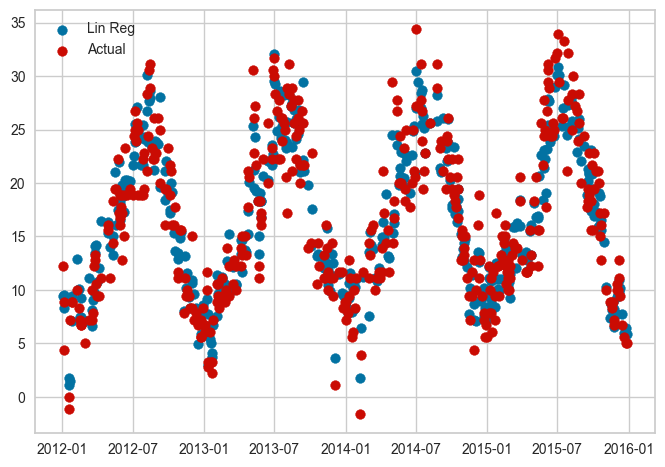

In [236]:
plt.scatter(X_test["date"], pred, label="Lin Reg", color="b")
plt.scatter(X_test["date"], y_test.values, label="Actual", color="r")
plt.legend()

In [237]:
print("R2 score:", r2_score(pred, y_test.values))
print("MSE:", mean_squared_error(pred, y_test.values)) # + or - temp_max on any particular day

R2 score: 0.8615930794913644
MSE: 6.611098416451716


/var/folders/1r/g44zbng11y9grgqnlkz32bdr0000gn/T/ipykernel_1156/328210055.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sn.heatmap(df.corr(), annot=True)


<Axes: >

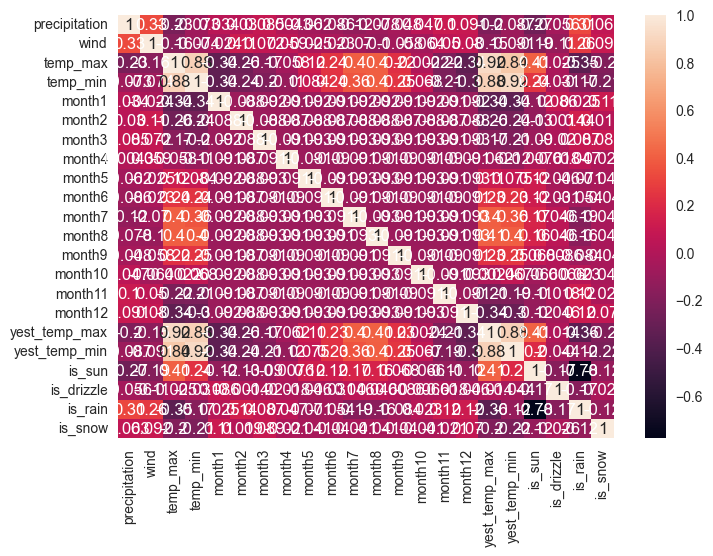

In [238]:

sn.heatmap(df.corr(), annot=True)


In [239]:
df = df.drop(columns=["month7", "month8"])

In [240]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["temp_max"]), df["temp_max"], test_size=0.3)
model = LinearRegression()
model.fit(X_train.drop(columns=["date"]).values, y_train.values)
pred = model.predict(X_test.drop(columns=["date"]).values)

/Users/danishsinghsethi/Desktop/applyai/venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/danishsinghsethi/Desktop/applyai/venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/danishsinghsethi/Desktop/applyai/venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/danishsinghsethi/Desktop/applyai/venv/lib/python3.8/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


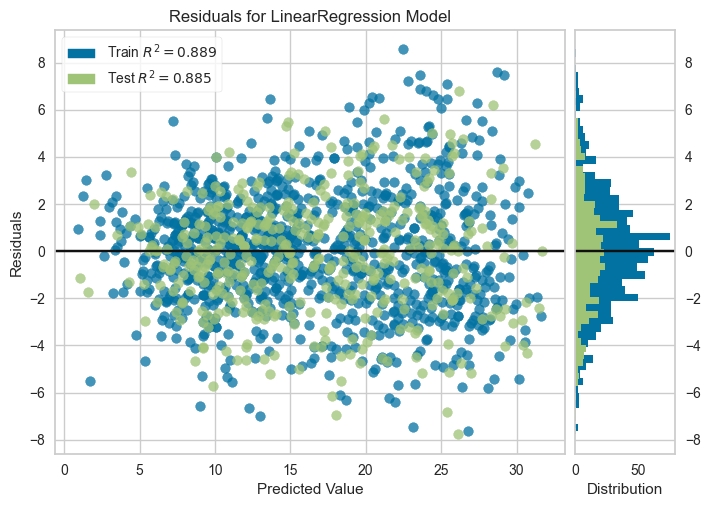

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [241]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train.drop(columns=["date"]), y_train)
visualizer.score(X_test.drop(columns=['date']), y_test)
visualizer.show()

In [242]:
print("R2 score:", r2_score(pred, y_test.values))
print("MSE:", mean_squared_error(pred, y_test.values)) # + or - temp_max on any particular day

R2 score: 0.8717554036889126
MSE: 5.746269684495123


In [243]:
X = df.drop(columns=['date', 'temp_max'])
y = df['temp_max']
model = sm.OLS(y, sm.add_constant(X)).fit()

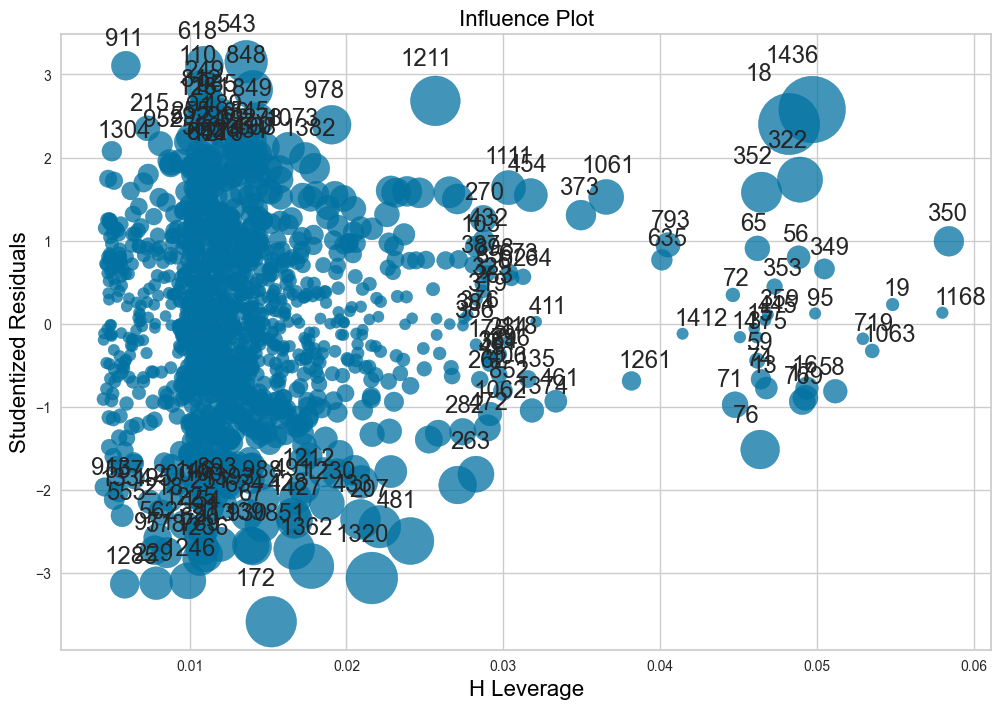

In [244]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [245]:
n = len(df)
influence = model.get_influence()
(cooks_distance, _) = influence.cooks_distance
outliers = np.where(cooks_distance > 4/n)[0]
df = df.drop(outliers)

In [246]:
X = df.drop(columns=['date', 'temp_max'])
y = df['temp_max']
model = sm.OLS(y, sm.add_constant(X)).fit()

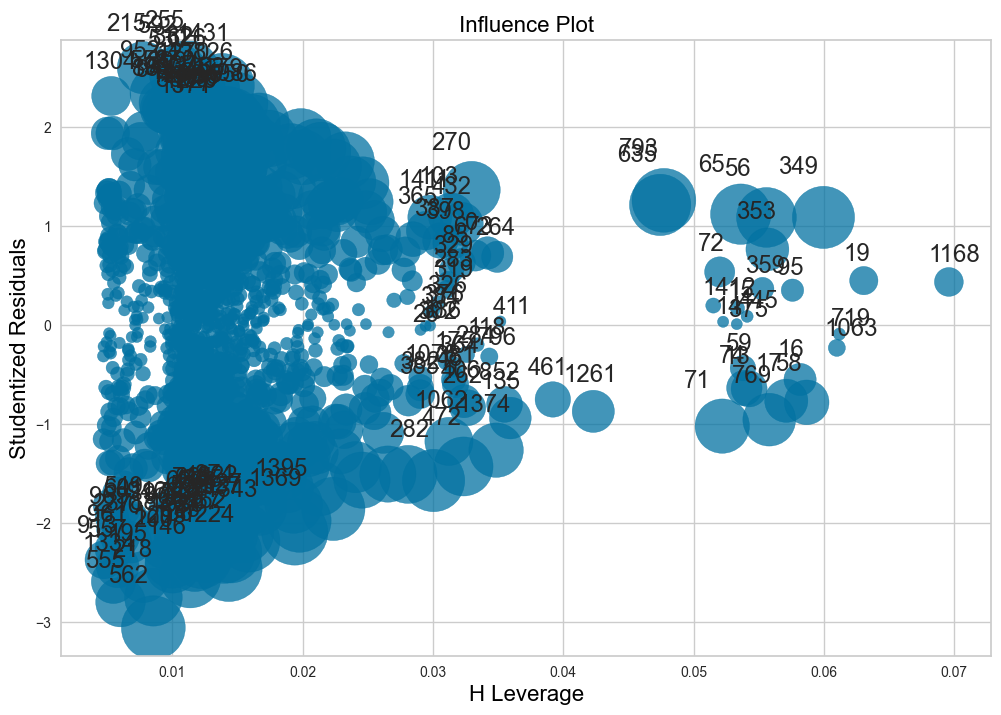

In [247]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks")

In [248]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["temp_max"]), df["temp_max"], test_size=0.3)
model = LinearRegression()
model.fit(X_train.drop(columns=["date"]).values, y_train.values)
pred = model.predict(X_test.drop(columns=["date"]).values)

In [249]:
print("R2 score:", r2_score(pred, y_test.values))
print("MSE:", mean_squared_error(pred, y_test.values)) # + or - temp_max on any particular day

R2 score: 0.9131201313182372
MSE: 4.428826167133217


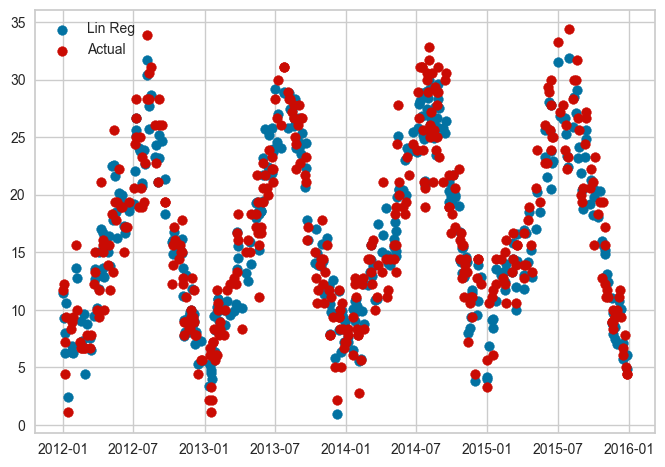

In [250]:
plt.scatter(X_test["date"], pred, label="Lin Reg", color="b")
plt.scatter(X_test["date"], y_test.values, label="Actual", color="r")
plt.legend()